In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The orderbook file contains the top 5 ask prices, bid prices and their respective order sizes. This is AMZN stock's one day limit order book dataset from LOBSTER database: https://lobsterdata.com/index.php

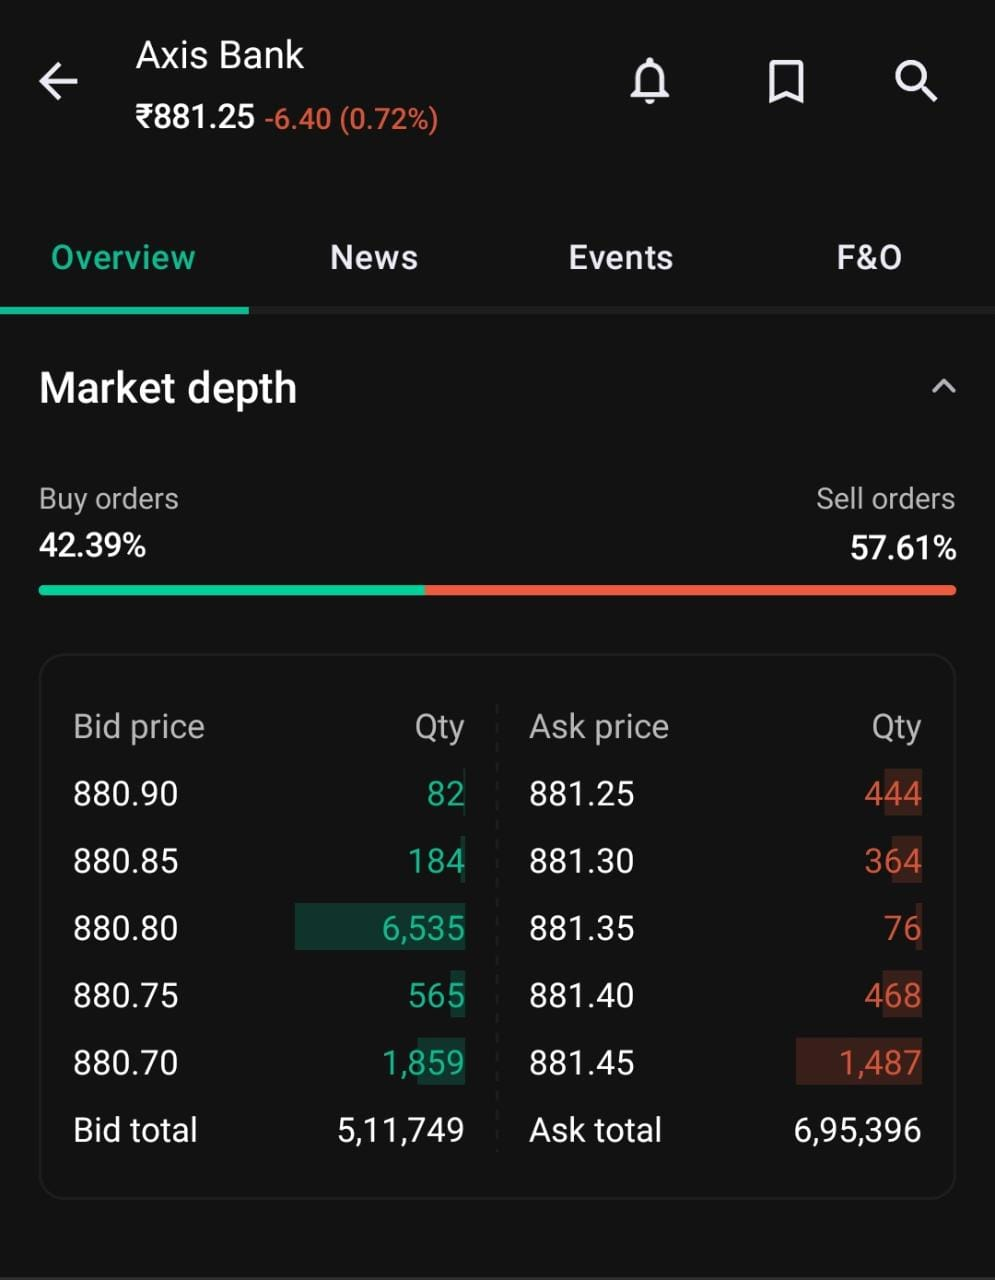

In [ ]:
orderbook=pd.read_csv("AMZN_2012-06-21_34200000_57600000_orderbook_5.csv",header=None)

In [ ]:
orderbook

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2239500,100,2231800,100,2239900,100,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10,2244000,547,2226200,100
1,2239500,100,2238100,21,2239900,100,2231800,100,2240000,220,2230700,200,2242500,100,2230400,100,2244000,547,2230000,10
2,2239500,100,2238100,21,2239600,20,2231800,100,2239900,100,2230700,200,2240000,220,2230400,100,2242500,100,2230000,10
3,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,2231800,100,2240000,220,2230700,200,2242500,100,2230400,100
4,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,2231800,100,2240000,233,2230700,200,2242500,100,2230400,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155930,2206200,100,2205100,249,2206400,100,2205000,71,2206500,1290,2204800,700,2206700,170,2204700,100,2206900,170,2204600,1704
155931,2206400,100,2205100,249,2206500,1290,2205000,71,2206700,170,2204800,700,2206900,170,2204700,100,2207100,1800,2204600,1704
155932,2206400,100,2205100,249,2206500,1290,2205000,71,2206700,170,2204800,700,2207100,1800,2204700,100,2207400,800,2204600,1704
155933,2206300,100,2205100,249,2206400,100,2205000,71,2206500,1290,2204800,700,2206700,170,2204700,100,2207100,1800,2204600,1704


The message file contains the timestamp values for our dataset. The time value is seconds after midnight.

In [ ]:
message=pd.read_csv("AMZN_2012-06-21_34200000_57600000_message_5.csv",header=None)

In [ ]:
message.head()

,0,1,2,3,4,5
0,34200.017460,5,0,1,2238200,-1
1,34200.189608,1,11885113,21,2238100,1
2,34200.189608,1,3911376,20,2239600,-1
3,34200.189608,1,11534792,100,2237500,1
4,34200.189608,1,1365373,13,2240000,-1


The mid-spread price is calculated to help with the reward calculations

In [ ]:
# Starting Ask Price
start_ask_price=2239500
start_bid_price=2231800
# Mid - Spread Value to evaluate results
mid_spread=(start_ask_price+start_bid_price)/2
mid_spread=mid_spread/10000
mid_spread

223.565

The required bid prices and timestamp values are extracted from the dataframes.

In [ ]:
data=orderbook.loc[:,[2,3,6,7,10,11,14,15,18,19]]

In [ ]:
data.columns=["bid1","size1","bid2","size2","bid3","size3","bid4","size4","bid5","size5"]
data["time"]=message.iloc[:,0]
data

,bid1,size1,bid2,size2,bid3,size3,bid4,size4,bid5,size5,time
0,2231800,100,2230700,200,2230400,100,2230000,10,2226200,100,34200.017460
1,2238100,21,2231800,100,2230700,200,2230400,100,2230000,10,34200.189608
2,2238100,21,2231800,100,2230700,200,2230400,100,2230000,10,34200.189608
3,2238100,21,2237500,100,2231800,100,2230700,200,2230400,100,34200.189608
4,2238100,21,2237500,100,2231800,100,2230700,200,2230400,100,34200.189608
...,...,...,...,...,...,...,...,...,...,...,...
155930,2205100,249,2205000,71,2204800,700,2204700,100,2204600,1704,57599.545828
155931,2205100,249,2205000,71,2204800,700,2204700,100,2204600,1704,57599.903989
155932,2205100,249,2205000,71,2204800,700,2204700,100,2204600,1704,57599.955242
155933,2205100,249,2205000,71,2204800,700,2204700,100,2204600,1704,57599.958245


This match_order function is used to execute a limit order after an action a is chosen. It takes in price p, volume v, and the array L of bid prices at that time instant are taken as arguments, and then executes a limit order of volume v at price p, and updates the remaining volume after matching with available order that are at prices greater than or equal to p, and returns the cash obtained from making the sale as well.

In [ ]:
def match_order(p,v,L):
  v_im,cash_im,v_existing,avg_price=0,0,0,0
  lis=[]
  for i in range(len(L)-1):
    if i%2==0:
      lis.append((L[i],L[i+1]))
  bid_p,bid_vol=lis.pop(0)
  while bid_p>=p and v>0 and len(lis)!=0:
    v_im += min(bid_vol,v)
    cash_im += min(bid_vol,v)*bid_p
    v -= min(bid_vol,v)
    bid_p,bid_vol=lis.pop(0)

    if p==0 and len(lis)==0:
      v_im += v
      cash_im += v * bid_p
      v=0
  # if no order is matched:

  return v_im,cash_im

The RL algorithm is executed in the below cell. First the dataset is dicretized into T time steps, and the latest bid price values after each time step value is taken as the required dataset of T points. As done in the paper, the hybrid algorithm of dynamic programming and Q-learning is implemented. The C- matrix (equivalent of Q-table in Q-learning)  is initialized to zero. The rewards are stored in c_t matrix. In the algorithm, at each state (t, i), all actions 'a' are executed to update all the values in the C-matrix using the rewards obtained. The algorithm goes through the entire dataset 20 times so that the C-matrix values converge to a stable value. The 'n' value in the C-matrix update equation represents the number of times the action 'a' is executed from state s(t,i)

In [ ]:
T=390*2
timestamps=[34200.01746+i/T*(57599.958245-34200.01746) for i in range(1,T+1)]
len(timestamps)

data_new=pd.DataFrame(columns=["bid1","size1","bid2","size2","bid3","size3","bid4","size4","bid5","size5","time"])
c=0
for i in range(len(data)):
  if(data.iloc[i,-1]>=timestamps[c]):
    data_new.loc[len(data_new),:]=data.iloc[i-1,:].values
    c=c+1

for i in [0,2,4,6,8]:
  data_new.iloc[:,i]= data_new.iloc[:,i]/10000


disc_data=data_new.copy()
V=500000
A=list(np.arange(-0.1,0.1,0.01))
I=100
C=np.zeros((T,I,len(A))) ## C((t,i,a))

c_t=np.zeros((T,I,len(A)))

for n in range(1,20):
  for t in range(T-1,-1,-1):
    data_row=list(disc_data.loc[t].values)
    data_row=data_row[:-1]
    for i in range(1,I+1):
      for a in range(len(A)):
        v_rem=i*V/I
        if t==T-1:
          v_t,cash_t=match_order(0,v_rem,data_row)
        else:
          v_t,cash_t=match_order(data_row[0]-A[a],v_rem,data_row)

        i_new=int((v_rem-v_t)/(V/I))

        c_t[t,i-1,a]=cash_t-v_t*mid_spread

        if t==T-1:
          C_min=min(C[t,i_new-1,:])
        else:
          C_min=min(C[t+1,i_new-1,:])

        # C-matrix update equation
        C[t,i-1,a]=(n/(n+1))*C[t,i-1,a] + (1/(n+1))*(c_t[t,i-1,a] + C_min )



The global optimal policy is deduced from the C-matrix and is displayed in dataframe policy. The policy dataframe describes the optimal action for every state s( t, i )

In [ ]:
policy=pd.DataFrame(columns=['State','Action'])
for t in range(T):
  for i in range(I):
    optimal_action=list(disc_data.loc[t].values)[0]-A[list(C[t,i,:]).index(C[t,i,:].max())]
    policy.loc[len(policy)]=[(t,i+1),"Execute a limit order at price "+str(round(optimal_action,4))]

In [ ]:
policy

,State,Action
0,"(0, 1)",Execute a limit order at price 224.09
1,"(0, 2)",Execute a limit order at price 224.09
2,"(0, 3)",Execute a limit order at price 224.09
3,"(0, 4)",Execute a limit order at price 224.09
4,"(0, 5)",Execute a limit order at price 224.09
...,...,...
77995,"(779, 96)",Execute a limit order at price 220.61
77996,"(779, 97)",Execute a limit order at price 220.61
77997,"(779, 98)",Execute a limit order at price 220.61
77998,"(779, 99)",Execute a limit order at price 220.61


The simulation run for executing the optimal action for this dataset is printed below. The run would start at s ( t, i) = s (0,100) representing that 100% of the shares are remaining to be sold at time t. All the state transitions from there on is printed in each line. We see that the entire volume of V shares is fully sold at time step 131.

In [ ]:
t=0
i=99
T_list=[t]
I_list=[i+1]
price_list=[]
bid_list=[]
while i:
  print("State: Time= "+str(t)+", I= "+str(i+1))
  data_row=list(disc_data.loc[t].values)
  data_row=data_row[:-1]
  v_rem=i*V/I
  if t==T-1:
    v_t,cash_t=match_order(0,v_rem,data_row)
  else:
    v_t,cash_t=match_order(data_row[0]-A[list(C[t,i,:]).index(C[t,i,:].max())],v_rem,data_row)

  i_new=int((v_rem-v_t)/(V/I))

  t=t+1
  i=i_new
  T_list.append(t)
  I_list.append(i+1)
  price_list.append(data_row[0]-A[list(C[t,i,:]).index(C[t,i,:].max())])
  bid_list.append(data_row[0])


print("State: Time= "+str(t)+", I= "+str(i+1))

State: Time= 0, I= 100
State: Time= 1, I= 99
State: Time= 2, I= 98
State: Time= 3, I= 97
State: Time= 4, I= 97
State: Time= 5, I= 97
State: Time= 6, I= 97
State: Time= 7, I= 96
State: Time= 8, I= 95
State: Time= 9, I= 94
State: Time= 10, I= 93
State: Time= 11, I= 92
State: Time= 12, I= 91
State: Time= 13, I= 90
State: Time= 14, I= 89
State: Time= 15, I= 88
State: Time= 16, I= 87
State: Time= 17, I= 86
State: Time= 18, I= 85
State: Time= 19, I= 84
State: Time= 20, I= 83
State: Time= 21, I= 82
State: Time= 22, I= 81
State: Time= 23, I= 80
State: Time= 24, I= 79
State: Time= 25, I= 78
State: Time= 26, I= 77
State: Time= 27, I= 76
State: Time= 28, I= 75
State: Time= 29, I= 74
State: Time= 30, I= 73
State: Time= 31, I= 72
State: Time= 32, I= 72
State: Time= 33, I= 71
State: Time= 34, I= 70
State: Time= 35, I= 69
State: Time= 36, I= 68
State: Time= 37, I= 67
State: Time= 38, I= 66
State: Time= 39, I= 65
State: Time= 40, I= 64
State: Time= 41, I= 63
State: Time= 42, I= 62
State: Time= 43, I= 

Text(0, 0.5, 'Shares Remaining (%)')

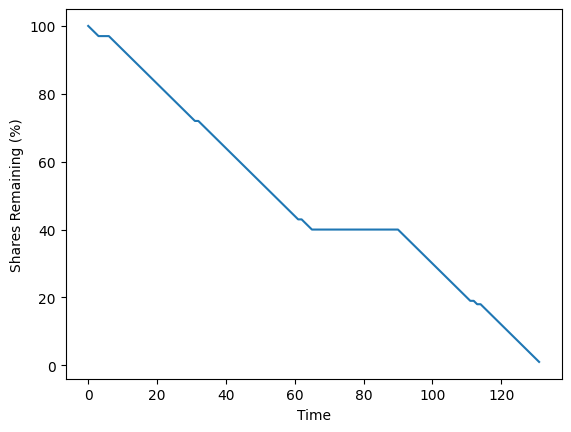

In [ ]:
plt.plot(T_list,I_list)
plt.xlabel("Time")
plt.ylabel("Shares Remaining (%)")

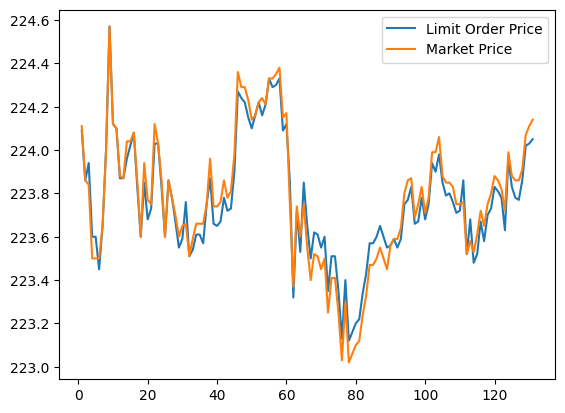

In [ ]:
plt.plot(T_list[1:],price_list)
plt.plot(T_list[1:],bid_list)
plt.legend(['Limit Order Price','Market Price'])
plt.show()

From this plot, we can see that at the times when limit order price is greater than the market price, the i vs t graph is flat because no order can be executed at a price higher than the current bid price.

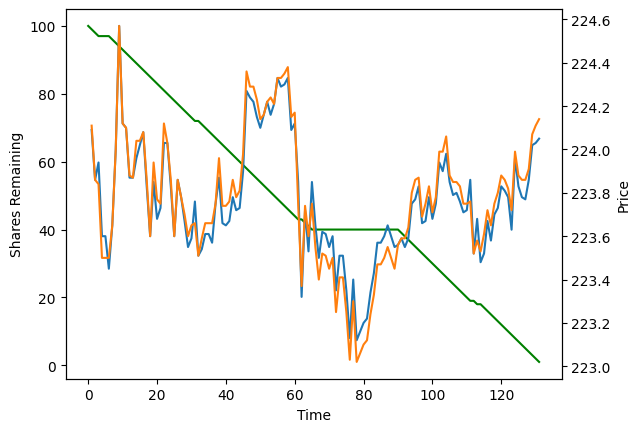

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(T_list,I_list,'g-')
ax2.plot(T_list[1:],price_list)
ax2.plot(T_list[1:],bid_list)

ax1.set_xlabel('Time')
ax1.set_ylabel('Shares Remaining')
ax2.set_ylabel('Price')

plt.show()

**The entire implementation is now done for time horizon H. The previous code executes the selling of V shares across the entire day. The code below executes the selling of V shares within time horizon H, as done in paper. Any shares remaining after time H has elapsed will be instantly sold at market price, however poor the prices may be**

In [ ]:
H=10000 # Time horizon in seconds
T=390*2
data_hor=data[data['time']<=34200.01746+H]
timestamps=[34200.01746+i/T*(data_hor.iloc[-1,-1]-data_hor.iloc[0,-1]) for i in range(1,T+1)]
len(timestamps)

780

In [ ]:
data_new=pd.DataFrame(columns=["bid1","size1","bid2","size2","bid3","size3","bid4","size4","bid5","size5","time"])
c=0
for i in range(len(data_hor)):
  if(data_hor.iloc[i,-1]>=timestamps[c]):
    data_new.loc[len(data_new),:]=data_hor.iloc[i-1,:].values
    c=c+1

for i in [0,2,4,6,8]:
  data_new.iloc[:,i]= data_new.iloc[:,i]/10000
data_new.loc[len(data_new)]=data_new.iloc[-1,:]



disc_data=data_new.copy()
V=500000
A=list(np.arange(-0.1,0.1,0.01))
I=100
C=np.zeros((T,I,len(A))) ## C((t,i,a))

c_t=np.zeros((T,I,len(A)))

for n in range(1,20):
  for t in range(T-1,-1,-1):
    data_row=list(disc_data.loc[t].values)
    data_row=data_row[:-1]
    for i in range(1,I+1):
      for a in range(len(A)):
        v_rem=i*V/I
        if t==T-1:
          v_t,cash_t=match_order(0,v_rem,data_row)
        else:
          v_t,cash_t=match_order(data_row[0]-A[a],v_rem,data_row)

        i_new=int((v_rem-v_t)/(V/I))

        c_t[t,i-1,a]=cash_t-v_t*mid_spread

        if t==T-1:
          C_min=min(C[t,i_new-1,:])
        else:
          C_min=min(C[t+1,i_new-1,:])

        C[t,i-1,a]=(n/(n+1))*C[t,i-1,a] + (1/(n+1))*(c_t[t,i-1,a] + C_min )



In [ ]:
policy=pd.DataFrame(columns=['State','Action'])
for t in range(T):
  for i in range(I):
    optimal_action=list(disc_data.loc[t].values)[0]-A[list(C[t,i,:]).index(C[t,i,:].max())]
    policy.loc[len(policy)]=[(t,i+1),"Execute a limit order at price "+str(round(optimal_action,4))]

In [ ]:
policy

In [ ]:
t=0
i=99
T_list=[t]
I_list=[i+1]
price_list=[]
bid_list=[]
while i:
  print("State: Time= "+str(t)+", I= "+str(i+1))
  data_row=list(disc_data.loc[t].values)
  data_row=data_row[:-1]
  v_rem=i*V/I
  if t==T-1:
    v_t,cash_t=match_order(0,v_rem,data_row)
  else:
    v_t,cash_t=match_order(data_row[0]-A[list(C[t,i,:]).index(C[t,i,:].max())],v_rem,data_row)

  i_new=int((v_rem-v_t)/(V/I))

  t=t+1
  i=i_new
  T_list.append(t)
  I_list.append(i+1)
  price_list.append(data_row[0]-A[list(C[t,i,:]).index(C[t,i,:].max())])
  bid_list.append(data_row[0])


print("State: Time= "+str(t)+", I= "+str(i+1))

In [ ]:
plt.plot(T_list,I_list)
plt.xlabel("Time")
plt.ylabel("Shares Remaining (%)")

In [ ]:
plt.plot(T_list[1:],price_list)
plt.plot(T_list[1:],bid_list)
plt.legend(['Limit Order Price','Market Price'])
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(T_list,I_list,'g-')
ax2.plot(T_list[1:],price_list)
ax2.plot(T_list[1:],bid_list)

ax1.set_xlabel('Time')
ax1.set_ylabel('Shares Remaining')
ax2.set_ylabel('Price')

plt.show()